In [1]:
import random, gym, math
from gym import error, spaces
import pandas as pd
import numpy as np
from enum import Enum
from stockstats import StockDataFrame
# from tensorboardX import SummaryWriter

import gym

import tensorflow as tf
from stable_baselines.common.policies import MlpPolicy, CnnPolicy, MlpLstmPolicy, ActorCriticPolicy, LstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines import PPO2, PPO1, A2C, DQN, TD3, SAC, ACER

# from stable_baselines3.common.policies import MlpPolicy
# from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import DummyVecEnv
# from stable_baselines3.common.evaluation import evaluate_policy

from sklearn import preprocessing

import datetime
import backtrader as bt
import backtrader.indicators as bi
from backtrader.feeds import PandasData

import matplotlib.pyplot as plt

from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo, Blackly

d:\soft\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\soft\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\soft\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\soft\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

Loading BokehJS ...

In [2]:
from lutils.stock import LTdxHq

In [3]:
# result = pd.read_pickle('d:/d.pkl')

In [4]:
# result[y_kmeans==5]

In [5]:
MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_NUM_AMOUNTS = 2147483647
MAX_SHARE_PRICE = 5000
MAX_OPEN_POSITIONS = 60
MAX_STEPS = 240 # 40000
NEXT_OBSERVATION_SIZE = 10

INITIAL_ACCOUNT_BALANCE = 10000

# writer = SummaryWriter('log')

In [6]:
# ltdxhq = LTdxHq()
# code = '603636' # 603828 603828 000032 300142 603636 600519
# # df = ltdxhq.get_k_data_1min(code, end='2021-09-02') # 000032 300142 603636 600519
# df = ltdxhq.get_k_data_daily(code, end='2021-01-01') # 000032 300142 603636 600519
# df = StockDataFrame(df.rename(columns={'vol': 'volume'}))
# # df['macd']
# # df['kdjk']
# # df['rsi_6']
# # df['rsi_12']

# # df_eval = ltdxhq.get_k_data_1min(code, start='2021-08-10')
# df_eval = ltdxhq.get_k_data_daily(code, start='2021-01-01')
# df_eval = StockDataFrame(df_eval.rename(columns={'vol': 'volume'}))

# ltdxhq.close()

In [7]:
# ltdxhq = LTdxHq()

# codes = ['603636', ] # '603828', '603828', '000032', '300142', '603636', '600519'
# dfs = []
# for code in codes:
#     _df = ltdxhq.get_k_data_daily(code, end='2021-01-01')
# #     _df = StockDataFrame(_df.rename(columns={'vol': 'volume'}))
#     _df = _df.rename(columns={'vol': 'volume'})
    
#     _df = _df.assign(open_normal = _df.open / _df.open.max())
#     _df = _df.assign(close_normal = _df.close / _df.close.max())
#     _df = _df.assign(high_normal = _df.high / _df.high.max())
#     _df = _df.assign(low_normal = _df.low / _df.low.max())
#     _df = _df.assign(volume_normal = _df.volume / _df.volume.max())
#     _df = _df.assign(amount_normal = _df.amount / _df.amount.max())
    
#     dfs.append(_df) # / _df.max())

# df = pd.concat(dfs)

# df_evals = []
# for code in codes:
#     _df = ltdxhq.get_k_data_daily(code, start='2021-01-01')
#     _df = _df.rename(columns={'vol': 'volume'})
    
#     _df = _df.assign(open_normal = _df.open / _df.open.max())
#     _df = _df.assign(close_normal = _df.close / _df.close.max())
#     _df = _df.assign(high_normal = _df.high / _df.high.max())
#     _df = _df.assign(low_normal = _df.low / _df.low.max())
#     _df = _df.assign(volume_normal = _df.volume / _df.volume.max())
#     _df = _df.assign(amount_normal = _df.amount / _df.amount.max())
    
#     df_evals.append(_df)
# ltdxhq.close()

In [8]:
ltdxhq = LTdxHq()

# codes = ['603636', '603828', '688698', '000032', '300142', '603636', ] # '600519'
codes = ['600603', '600583', '600582', '600565', '600558', '600551',
       '600509', '600503', '600488', '600469', '600439', '600433',
       '600428', '600425', '600387', '600383', '600382', '600369',
       '600339', '600337', '600335', '600326', '600320', '600312',
       '002666', '002654', '002641', '002628', '002627', '002620',
       '002608', '002593', '002586', '002582', '002566', '002560',]
dfs = []
df_evals = []
for code in codes:
    _df = ltdxhq.get_k_data_daily(code)
#     _df = StockDataFrame(_df.rename(columns={'vol': 'volume'}))
    _df = _df.rename(columns={'vol': 'volume'})
    
    _df = _df.assign(open_normal = _df.open / _df.open.max())
    _df = _df.assign(close_normal = _df.close / _df.close.max())
    _df = _df.assign(high_normal = _df.high / _df.high.max())
    _df = _df.assign(low_normal = _df.low / _df.low.max())
    _df = _df.assign(volume_normal = _df.volume / _df.volume.max())
    _df = _df.assign(amount_normal = _df.amount / _df.amount.max())
    
    dfs.append(_df.loc[:'2021-01-01']) # / _df.max())
    df_evals.append(_df.loc['2021-01-01':])
    
df = pd.concat(dfs)

ltdxhq.close()

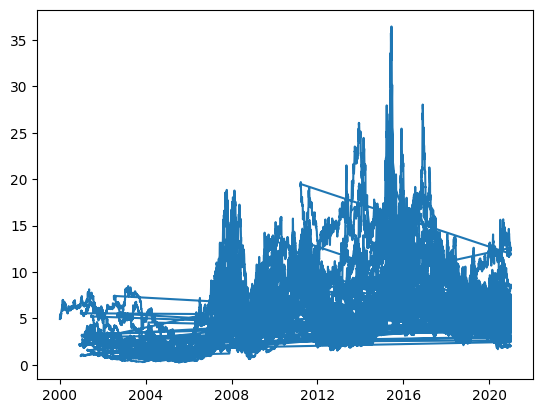

In [9]:
plt.plot(df.close)
plt.show()

In [10]:
df

,open,close,high,low,volume,amount,open_normal,close_normal,high_normal,low_normal,volume_normal,amount_normal
date,,,,,,,,,,,,
2000-01-04,4.78,4.94,4.95,4.77,1400800.0,19873510.0,0.469087,0.477756,0.455801,0.472277,0.014870,0.022972
2000-01-05,4.93,5.19,5.43,4.86,7043100.0,107845504.0,0.483808,0.501934,0.500000,0.481188,0.074764,0.124658
2000-01-06,5.13,5.35,5.37,5.07,2145300.0,32499732.0,0.503435,0.517408,0.494475,0.501980,0.022773,0.037566
2000-01-07,5.35,5.43,5.61,5.27,7018700.0,110908752.0,0.525025,0.525145,0.516575,0.521782,0.074505,0.128199
2000-01-10,5.44,5.48,5.60,5.33,5804700.0,92433640.0,0.533857,0.529981,0.515654,0.527723,0.061618,0.106843
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,8.38,8.57,8.65,8.32,7890620.0,67008188.0,0.490058,0.520024,0.492316,0.517735,0.061927,0.043108
2020-12-28,8.55,8.35,8.59,8.25,7404903.0,61921968.0,0.500000,0.506675,0.488902,0.513379,0.058115,0.039836
2020-12-29,8.35,8.35,8.52,8.33,5257100.0,44167640.0,0.488304,0.506675,0.484917,0.518357,0.041259,0.028414


In [11]:
class Actions(Enum):
    Hold = 0
    Sell = 1
    Buy = 2

In [12]:
class LStockDailyEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(LStockDailyEnv, self).__init__()

#         self.df = df / df.max()
#         self.max = df.max()
        self.df = df
        self.max = df.max()

        self.current_step = NEXT_OBSERVATION_SIZE - 1

#         self.reward_range = (-np.inf, np.inf)
        self.reward_range = (-1, 1)

#         self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)
        self.action_space = spaces.Discrete(len(Actions))
        
        self.observation_space = spaces.Box(low=-1, high=1, shape=(6, NEXT_OBSERVATION_SIZE + 1), dtype=np.float16)
#         self.min_max_scaler = preprocessing.MinMaxScaler()

    def _next_observation(self):
        # Get the stock data points for the last 5 days and scale to between 0-1
        frame = np.array([
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['open'].values / MAX_SHARE_PRICE,
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['high'].values / MAX_SHARE_PRICE,
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['low'].values / MAX_SHARE_PRICE,
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['close'].values / MAX_SHARE_PRICE,
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['vol'].values / MAX_NUM_SHARES,

            # self.df['macd'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # self.df['macdh'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # self.df['macds'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # # self.df['volume_delta'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # # self.df['open_2_d'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # # self.df['open_-2_r'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # # self.df['cr'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # # self.df['cr-ma1'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # # self.df['cr-ma2'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # # self.df['cr-ma3'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # self.df['kdjk'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # self.df['kdjd'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # self.df['kdjj'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # self.df['open_2_sma'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['dma'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['pdi'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['mdi'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['dx'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['adx'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['adxr'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # # self.df['tema'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # # self.df['vr'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # # self.df['vr_6_sma'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,

#             self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['open'].values / MAX_SHARE_PRICE,
#             self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['high'].values / MAX_SHARE_PRICE,
#             self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['low'].values / MAX_SHARE_PRICE,
#             self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['close'].values / MAX_SHARE_PRICE,
#             self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['volume'].values / MAX_NUM_SHARES,
#             self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['amount'].values / MAX_NUM_SHARES,

#             self.df['macd'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
#             self.df['macdh'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
#             self.df['macds'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
#             self.df['kdjk'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
#             self.df['kdjd'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
#             self.df['kdjj'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,

#             self.df['rsi_6'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
#             self.df['rsi_12'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
            
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['open_normal'].values,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['high_normal'].values,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['low_normal'].values,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['close_normal'].values,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['volume_normal'].values,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['amount_normal'].values,

        ])
        
        bal = np.ones([6, 1]) * self.balance / self.net_worth
#         act = np.ones([6, 1]) * action / 2
        
        frame = np.hstack([frame, bal, ]) # act
        
#         print(frame)
#         print('##########')
#         frame = self.min_max_scaler.fit_transform(frame)
# #         frame = pd.DataFrame(min_max_scaler.fit_transform(df), index=df.index, columns=df.columns)
# #         frame = self.scaler.fit_transform(frame)
#         print(frame)
#         print('*****************')
        
        return frame

    def _take_action(self, action):
        current_price = self.df.iloc[self.current_step]['close'] # + 0.02
        tomorrow_price = self.df.iloc[self.current_step + 1]['close'] # + 0.02
        
        if action == Actions.Buy.value:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible / 100)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price * 100

            self.balance -= additional_cost
            self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action == Actions.Sell.value:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held)
            self.balance += shares_sold * current_price * 100
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

        self.net_worth = self.balance + self.shares_held * tomorrow_price * 100
        
#         print(self.balance, self.net_worth, self.shares_held, current_price)
        
        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        if self.shares_held == 0:
            self.cost_basis = 0
        
        
    def step(self, action):
        # Execute one time step within the environment
        shares_held = self.shares_held
        self._take_action(action)
        obs = self._next_observation()
        
        reward = 0
        
#         done = ((self.current_step + 1) >= self.df.shape[0] 
#                 or self.net_worth <= INITIAL_ACCOUNT_BALANCE * .5 
#                 or self.df.index[self.current_step].weekday() == 4 )
        done = ((self.current_step + 2) >= self.df.shape[0] 
                or self.net_worth <= INITIAL_ACCOUNT_BALANCE * .5 
                or action == Actions.Sell.value)
        
#         if not done:
# #             if action_type < 1: # Buy
# #                 reward = self.df.iloc[self.current_step + 1]['close'] - self.df.iloc[self.current_step]['close']
# #             elif action_type >= 1 and action_type < 2: # Sell
# #                 reward = self.df.iloc[self.current_step]['close'] - self.df.iloc[self.current_step + 1]['close']
# #             else: # Hold
# #                 reward = self.net_worth - self.old_net_worth # self.df.iloc[self.current_step + 1]['close'] - self.df.iloc[self.current_step]['close']
            
#             reward = self.df.iloc[self.current_step + 1]['close'] - self.df.iloc[self.current_step]['close']
#             if (self.shares_held <= 0 and reward > 0) or (self.shares_held > 0 and reward < 0):
#                 reward = -reward
            
#             if action == Actions.Buy.value: # buy
#                 if self.old_balance == self.balance:
#                     reward = reward * .5
#                 else:
#                     reward = reward
#             elif action == Actions.Sell.value: # sell
#                 if self.old_balance == self.balance:
#                     reward = reward * .5
#                 else:
#                     reward = reward
#             elif action == Actions.Hold.value and self.shares_held <= 0:
#                 reward = -np.abs(reward) # -(np.abs(reward) / self.df.iloc[self.current_step + 1]['close'])
            
# #             print(action, reward)
#             self.old_balance = self.balance
#         else:
# #             reward = (self.net_worth - INITIAL_ACCOUNT_BALANCE) / INITIAL_ACCOUNT_BALANCE
# #             print(self.balance, reward)
#             reward = self.net_worth - INITIAL_ACCOUNT_BALANCE
        
#         self.old_net_worth = self.net_worth
#         self.current_step = self.current_step + 1
        
#         if done:
#             reward = (self.net_worth - INITIAL_ACCOUNT_BALANCE)
#         else:
#             reward = (self.net_worth - INITIAL_ACCOUNT_BALANCE) * (self.net_worth - INITIAL_ACCOUNT_BALANCE) / INITIAL_ACCOUNT_BALANCE
        
        
        assets = self.net_worth
        cash = self.balance
        cash_penalty = max(0, (assets * 0.1 - cash))
        assets -= cash_penalty
        reward = (assets / INITIAL_ACCOUNT_BALANCE) - 1
        reward /= self.current_step
        
        ddd.append([self.net_worth, reward, action, self.current_step])
        
        self.current_step = self.current_step + 1
        return obs, reward, done, {'net_worth': self.net_worth}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.old_balance = self.balance
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.old_net_worth = self.net_worth
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        self.current_step = self.current_step + 1
        if (self.current_step + 5) >= self.df.shape[0]:
            self.current_step = NEXT_OBSERVATION_SIZE

        return self._next_observation()

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')

In [13]:
# env = DummyVecEnv([lambda: LStockDailyEnv(df)])
# policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[256, 256], pi=[256, 256])])

# model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model.learn(total_timesteps=100000)
# # model.save('ppo_stock')

In [14]:
ddd = []

In [15]:
env = DummyVecEnv([lambda: LStockDailyEnv(df)])
# policy_kwargs = dict(act_fun=tf.nn.tanh, net_arch=[256, 256, 'lstm', 256, dict(pi=[128, 64, 32, 16], vf=[128, 128, 128])])
# model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)

policy_kwargs = dict(net_arch=[256, 256, 256, dict(pi=[128, 64, 32, 16], vf=[128, 64, 32, 16])])
model = PPO2('MlpPolicy', env, verbose=1, policy_kwargs=policy_kwargs)

model.learn(total_timesteps=40000)
# model.save('ppo_stock')

-------------------------------------
| approxkl           | 0.0001488122 |
| clipfrac           | 0.0          |
| explained_variance | -3.04        |
| fps                | 331          |
| n_updates          | 1            |
| policy_entropy     | 1.0984755    |
| policy_loss        | -0.003652123 |
| serial_timesteps   | 128          |
| time_elapsed       | 0            |
| total_timesteps    | 128          |
| value_loss         | 0.036727432  |
-------------------------------------
--------------------------------------
| approxkl           | 0.00019827648 |
| clipfrac           | 0.0           |
| explained_variance | -15           |
| fps                | 841           |
| n_updates          | 2             |
| policy_entropy     | 1.0972503     |
| policy_loss        | -0.0022212495 |
| serial_timesteps   | 256           |
| time_elapsed       | 0.387         |
| total_timesteps    | 256           |
| value_loss         | 0.0021098845  |
--------------------------------------

--------------------------------------
| approxkl           | 1.8790393e-05 |
| clipfrac           | 0.0           |
| explained_variance | -27.9         |
| fps                | 809           |
| n_updates          | 16            |
| policy_entropy     | 1.0728239     |
| policy_loss        | 0.00027368567 |
| serial_timesteps   | 2048          |
| time_elapsed       | 2.56          |
| total_timesteps    | 2048          |
| value_loss         | 2.1776204e-05 |
--------------------------------------
--------------------------------------
| approxkl           | 0.00034479034 |
| clipfrac           | 0.0           |
| explained_variance | -4.66         |
| fps                | 804           |
| n_updates          | 17            |
| policy_entropy     | 1.076848      |
| policy_loss        | -0.005130598  |
| serial_timesteps   | 2176          |
| time_elapsed       | 2.72          |
| total_timesteps    | 2176          |
| value_loss         | 1.8204024e-05 |
-------------------------

--------------------------------------
| approxkl           | 6.69817e-05   |
| clipfrac           | 0.0           |
| explained_variance | -1.71         |
| fps                | 841           |
| n_updates          | 33            |
| policy_entropy     | 1.089255      |
| policy_loss        | -0.0012555413 |
| serial_timesteps   | 4224          |
| time_elapsed       | 5.18          |
| total_timesteps    | 4224          |
| value_loss         | 8.584718e-05  |
--------------------------------------
--------------------------------------
| approxkl           | 3.7413018e-05 |
| clipfrac           | 0.0           |
| explained_variance | -4.7          |
| fps                | 829           |
| n_updates          | 34            |
| policy_entropy     | 1.092689      |
| policy_loss        | -0.000593164  |
| serial_timesteps   | 4352          |
| time_elapsed       | 5.33          |
| total_timesteps    | 4352          |
| value_loss         | 5.3405027e-05 |
-------------------------

--------------------------------------
| approxkl           | 4.326208e-05  |
| clipfrac           | 0.0           |
| explained_variance | -19.2         |
| fps                | 830           |
| n_updates          | 50            |
| policy_entropy     | 1.0885686     |
| policy_loss        | -0.0015970769 |
| serial_timesteps   | 6400          |
| time_elapsed       | 7.77          |
| total_timesteps    | 6400          |
| value_loss         | 1.7963998e-06 |
--------------------------------------
--------------------------------------
| approxkl           | 2.9981882e-05 |
| clipfrac           | 0.0           |
| explained_variance | -143          |
| fps                | 780           |
| n_updates          | 51            |
| policy_entropy     | 1.0853432     |
| policy_loss        | 0.00051076105 |
| serial_timesteps   | 6528          |
| time_elapsed       | 7.93          |
| total_timesteps    | 6528          |
| value_loss         | 3.7326445e-06 |
-------------------------

--------------------------------------
| approxkl           | 6.8812005e-05 |
| clipfrac           | 0.0           |
| explained_variance | -195          |
| fps                | 858           |
| n_updates          | 67            |
| policy_entropy     | 1.098482      |
| policy_loss        | -0.0032039816 |
| serial_timesteps   | 8576          |
| time_elapsed       | 10.4          |
| total_timesteps    | 8576          |
| value_loss         | 1.5231213e-05 |
--------------------------------------
---------------------------------------
| approxkl           | 0.00012227394  |
| clipfrac           | 0.0            |
| explained_variance | -37.7          |
| fps                | 815            |
| n_updates          | 68             |
| policy_entropy     | 1.0983883      |
| policy_loss        | -0.00066783803 |
| serial_timesteps   | 8704           |
| time_elapsed       | 10.6           |
| total_timesteps    | 8704           |
| value_loss         | 2.25123e-05    |
-------------

--------------------------------------
| approxkl           | 0.00020466215 |
| clipfrac           | 0.0           |
| explained_variance | -6.91         |
| fps                | 830           |
| n_updates          | 84            |
| policy_entropy     | 1.0943353     |
| policy_loss        | -0.0034374632 |
| serial_timesteps   | 10752         |
| time_elapsed       | 13            |
| total_timesteps    | 10752         |
| value_loss         | 4.3678778e-05 |
--------------------------------------
--------------------------------------
| approxkl           | 0.00021784192 |
| clipfrac           | 0.0           |
| explained_variance | -14.1         |
| fps                | 804           |
| n_updates          | 85            |
| policy_entropy     | 1.0920757     |
| policy_loss        | -0.0021029578 |
| serial_timesteps   | 10880         |
| time_elapsed       | 13.2          |
| total_timesteps    | 10880         |
| value_loss         | 3.8766735e-05 |
-------------------------

--------------------------------------
| approxkl           | 0.0003856295  |
| clipfrac           | 0.0           |
| explained_variance | -50.7         |
| fps                | 847           |
| n_updates          | 101           |
| policy_entropy     | 1.0870899     |
| policy_loss        | -0.0039623035 |
| serial_timesteps   | 12928         |
| time_elapsed       | 15.6          |
| total_timesteps    | 12928         |
| value_loss         | 3.0550784e-06 |
--------------------------------------
--------------------------------------
| approxkl           | 2.1957509e-05 |
| clipfrac           | 0.0           |
| explained_variance | -163          |
| fps                | 858           |
| n_updates          | 102           |
| policy_entropy     | 1.0826995     |
| policy_loss        | 0.00086575584 |
| serial_timesteps   | 13056         |
| time_elapsed       | 15.8          |
| total_timesteps    | 13056         |
| value_loss         | 1.8150527e-05 |
-------------------------

---------------------------------------
| approxkl           | 0.0004997743   |
| clipfrac           | 0.0            |
| explained_variance | -10.7          |
| fps                | 841            |
| n_updates          | 118            |
| policy_entropy     | 1.073921       |
| policy_loss        | -0.00046160806 |
| serial_timesteps   | 15104          |
| time_elapsed       | 18.2           |
| total_timesteps    | 15104          |
| value_loss         | 2.920503e-06   |
---------------------------------------
-------------------------------------
| approxkl           | 0.006654712  |
| clipfrac           | 0.12109375   |
| explained_variance | -26.9        |
| fps                | 864          |
| n_updates          | 119          |
| policy_entropy     | 1.084493     |
| policy_loss        | -0.009687453 |
| serial_timesteps   | 15232        |
| time_elapsed       | 18.3         |
| total_timesteps    | 15232        |
| value_loss         | 3.984715e-06 |
------------------------

--------------------------------------
| approxkl           | 0.00051814195 |
| clipfrac           | 0.0           |
| explained_variance | -11.4         |
| fps                | 853           |
| n_updates          | 135           |
| policy_entropy     | 1.0641892     |
| policy_loss        | -0.0078663705 |
| serial_timesteps   | 17280         |
| time_elapsed       | 20.8          |
| total_timesteps    | 17280         |
| value_loss         | 1.212255e-05  |
--------------------------------------
--------------------------------------
| approxkl           | 0.00029934937 |
| clipfrac           | 0.0           |
| explained_variance | -3.83         |
| fps                | 841           |
| n_updates          | 136           |
| policy_entropy     | 1.0554959     |
| policy_loss        | -0.0029033914 |
| serial_timesteps   | 17408         |
| time_elapsed       | 21            |
| total_timesteps    | 17408         |
| value_loss         | 1.3889463e-05 |
-------------------------

---------------------------------------
| approxkl           | 4.4636938e-05  |
| clipfrac           | 0.0            |
| explained_variance | -80.1          |
| fps                | 807            |
| n_updates          | 152            |
| policy_entropy     | 1.0262672      |
| policy_loss        | -0.00024439627 |
| serial_timesteps   | 19456          |
| time_elapsed       | 23.5           |
| total_timesteps    | 19456          |
| value_loss         | 1.5236815e-06  |
---------------------------------------
---------------------------------------
| approxkl           | 5.0882704e-06  |
| clipfrac           | 0.0            |
| explained_variance | -49.8          |
| fps                | 830            |
| n_updates          | 153            |
| policy_entropy     | 1.0236698      |
| policy_loss        | -1.2297765e-05 |
| serial_timesteps   | 19584          |
| time_elapsed       | 23.6           |
| total_timesteps    | 19584          |
| value_loss         | 8.981226e-06   |


-------------------------------------
| approxkl           | 0.0002740904 |
| clipfrac           | 0.0          |
| explained_variance | -108         |
| fps                | 853          |
| n_updates          | 169          |
| policy_entropy     | 1.0327957    |
| policy_loss        | -0.004851375 |
| serial_timesteps   | 21632        |
| time_elapsed       | 26.1         |
| total_timesteps    | 21632        |
| value_loss         | 5.595539e-07 |
-------------------------------------
--------------------------------------
| approxkl           | 0.00030718575 |
| clipfrac           | 0.0           |
| explained_variance | -225          |
| fps                | 841           |
| n_updates          | 170           |
| policy_entropy     | 1.0503582     |
| policy_loss        | -0.0019046608 |
| serial_timesteps   | 21760         |
| time_elapsed       | 26.2          |
| total_timesteps    | 21760         |
| value_loss         | 1.7653622e-06 |
--------------------------------------

--------------------------------------
| approxkl           | 2.4026273e-05 |
| clipfrac           | 0.0           |
| explained_variance | -8.14         |
| fps                | 825           |
| n_updates          | 186           |
| policy_entropy     | 1.0830975     |
| policy_loss        | 0.0007028477  |
| serial_timesteps   | 23808         |
| time_elapsed       | 28.6          |
| total_timesteps    | 23808         |
| value_loss         | 3.833747e-05  |
--------------------------------------
--------------------------------------
| approxkl           | 0.00013849135 |
| clipfrac           | 0.0           |
| explained_variance | -3.59         |
| fps                | 828           |
| n_updates          | 187           |
| policy_entropy     | 1.0843527     |
| policy_loss        | -0.0029931597 |
| serial_timesteps   | 23936         |
| time_elapsed       | 28.8          |
| total_timesteps    | 23936         |
| value_loss         | 7.5875264e-06 |
-------------------------

--------------------------------------
| approxkl           | 0.00032225836 |
| clipfrac           | 0.0           |
| explained_variance | -286          |
| fps                | 845           |
| n_updates          | 203           |
| policy_entropy     | 1.0642402     |
| policy_loss        | -0.0026835103 |
| serial_timesteps   | 25984         |
| time_elapsed       | 31.3          |
| total_timesteps    | 25984         |
| value_loss         | 5.1012275e-06 |
--------------------------------------
--------------------------------------
| approxkl           | 5.0337476e-05 |
| clipfrac           | 0.0           |
| explained_variance | -53.8         |
| fps                | 789           |
| n_updates          | 204           |
| policy_entropy     | 1.0551672     |
| policy_loss        | 0.00035644067 |
| serial_timesteps   | 26112         |
| time_elapsed       | 31.5          |
| total_timesteps    | 26112         |
| value_loss         | 5.0847393e-07 |
-------------------------

---------------------------------------
| approxkl           | 5.4398188e-05  |
| clipfrac           | 0.0            |
| explained_variance | -4.92          |
| fps                | 797            |
| n_updates          | 220            |
| policy_entropy     | 1.0796486      |
| policy_loss        | -9.0247835e-05 |
| serial_timesteps   | 28160          |
| time_elapsed       | 34             |
| total_timesteps    | 28160          |
| value_loss         | 1.7982806e-06  |
---------------------------------------
---------------------------------------
| approxkl           | 4.500444e-05   |
| clipfrac           | 0.0            |
| explained_variance | -380           |
| fps                | 847            |
| n_updates          | 221            |
| policy_entropy     | 1.0819932      |
| policy_loss        | -0.00016502506 |
| serial_timesteps   | 28288          |
| time_elapsed       | 34.1           |
| total_timesteps    | 28288          |
| value_loss         | 1.8467193e-06  |


---------------------------------------
| approxkl           | 1.08886925e-05 |
| clipfrac           | 0.0            |
| explained_variance | -59.3          |
| fps                | 815            |
| n_updates          | 236            |
| policy_entropy     | 1.0827773      |
| policy_loss        | 0.00030731526  |
| serial_timesteps   | 30208          |
| time_elapsed       | 36.4           |
| total_timesteps    | 30208          |
| value_loss         | 1.1726543e-06  |
---------------------------------------
--------------------------------------
| approxkl           | 0.00010247004 |
| clipfrac           | 0.0           |
| explained_variance | -95.8         |
| fps                | 836           |
| n_updates          | 237           |
| policy_entropy     | 1.084869      |
| policy_loss        | -0.0013223358 |
| serial_timesteps   | 30336         |
| time_elapsed       | 36.6          |
| total_timesteps    | 30336         |
| value_loss         | 2.974382e-07  |
------------

--------------------------------------
| approxkl           | 2.9700268e-05 |
| clipfrac           | 0.0           |
| explained_variance | -128          |
| fps                | 836           |
| n_updates          | 253           |
| policy_entropy     | 1.0912701     |
| policy_loss        | -0.0003095551 |
| serial_timesteps   | 32384         |
| time_elapsed       | 39.1          |
| total_timesteps    | 32384         |
| value_loss         | 7.906167e-08  |
--------------------------------------
---------------------------------------
| approxkl           | 2.7127644e-05  |
| clipfrac           | 0.0            |
| explained_variance | -246           |
| fps                | 801            |
| n_updates          | 254            |
| policy_entropy     | 1.0918221      |
| policy_loss        | -0.00017843884 |
| serial_timesteps   | 32512          |
| time_elapsed       | 39.2           |
| total_timesteps    | 32512          |
| value_loss         | 1.6407375e-07  |
-------------

-------------------------------------
| approxkl           | 2.619376e-05 |
| clipfrac           | 0.0          |
| explained_variance | -106         |
| fps                | 841          |
| n_updates          | 270          |
| policy_entropy     | 1.0836629    |
| policy_loss        | 5.551707e-05 |
| serial_timesteps   | 34560        |
| time_elapsed       | 41.7         |
| total_timesteps    | 34560        |
| value_loss         | 7.311409e-08 |
-------------------------------------
--------------------------------------
| approxkl           | 3.5476733e-05 |
| clipfrac           | 0.0           |
| explained_variance | -33.9         |
| fps                | 815           |
| n_updates          | 271           |
| policy_entropy     | 1.0837574     |
| policy_loss        | -0.0006988443 |
| serial_timesteps   | 34688         |
| time_elapsed       | 41.8          |
| total_timesteps    | 34688         |
| value_loss         | 5.43007e-07   |
--------------------------------------

---------------------------------------
| approxkl           | 9.787876e-05   |
| clipfrac           | 0.0            |
| explained_variance | -136           |
| fps                | 847            |
| n_updates          | 287            |
| policy_entropy     | 1.082706       |
| policy_loss        | -0.00085286435 |
| serial_timesteps   | 36736          |
| time_elapsed       | 44.3           |
| total_timesteps    | 36736          |
| value_loss         | 8.4703254e-07  |
---------------------------------------
---------------------------------------
| approxkl           | 2.261801e-05   |
| clipfrac           | 0.0            |
| explained_variance | -26.5          |
| fps                | 841            |
| n_updates          | 288            |
| policy_entropy     | 1.084985       |
| policy_loss        | -1.6510603e-05 |
| serial_timesteps   | 36864          |
| time_elapsed       | 44.5           |
| total_timesteps    | 36864          |
| value_loss         | 2.1120886e-07  |


--------------------------------------
| approxkl           | 0.00016131482 |
| clipfrac           | 0.0           |
| explained_variance | -18.7         |
| fps                | 825           |
| n_updates          | 304           |
| policy_entropy     | 1.0934335     |
| policy_loss        | -0.0017831943 |
| serial_timesteps   | 38912         |
| time_elapsed       | 47            |
| total_timesteps    | 38912         |
| value_loss         | 2.6958836e-07 |
--------------------------------------
---------------------------------------
| approxkl           | 3.813203e-05   |
| clipfrac           | 0.0            |
| explained_variance | -38.4          |
| fps                | 853            |
| n_updates          | 305            |
| policy_entropy     | 1.095236       |
| policy_loss        | -0.00018528954 |
| serial_timesteps   | 39040          |
| time_elapsed       | 47.1           |
| total_timesteps    | 39040          |
| value_loss         | 2.3545225e-07  |
-------------

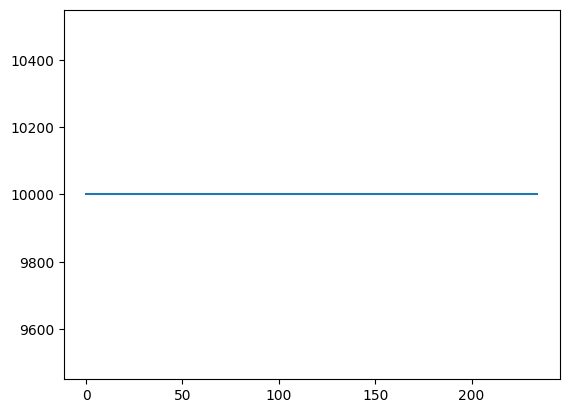

In [16]:
eval_index = 2
eval_env = DummyVecEnv([lambda: LStockDailyEnv(df_evals[eval_index])])
obs = eval_env.reset()

net_worths = []
actions = [Actions.Hold.value] * NEXT_OBSERVATION_SIZE
done, state = False, None
# while not done:

df_evals[eval_index].shape[0]
for _ in range(NEXT_OBSERVATION_SIZE, df_evals[eval_index].shape[0]):
#     print(obs)
    action, state = model.predict(obs, state=state, deterministic=True)
#     print(action)
    obs, reward, done, _info = eval_env.step(action)
    net_worths.append(_info[0]['net_worth'])
    
    actions.append(action[0])
#     eval_env.render()
    
dff = df_evals[eval_index].assign(action=actions)

dff = dff.drop(['open_normal', 'close_normal', 'high_normal', 'low_normal', 'volume_normal', 'amount_normal'], axis=1)

plt.plot(net_worths)
plt.show()

In [17]:
len(ddd)

40171

In [18]:
dddf = np.array(ddd)
dddf.shape

(40171, 4)

In [19]:
dddf[:,2][-100:]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

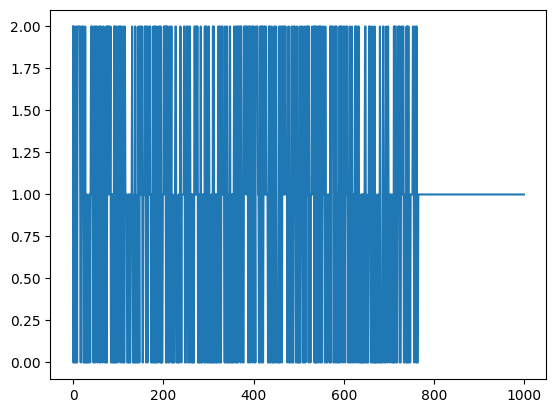

In [20]:
plt.plot(dddf[:,2][-1000:]) #, '.')
plt.show()

In [21]:
actions

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [77]:
dff

,open,close,high,low,volume,amount,action
date,,,,,,,
2021-01-04,2.99,2.99,3.02,2.94,40315824.0,123802240.0,0
2021-01-05,2.98,2.98,2.99,2.93,30595052.0,93401360.0,0
2021-01-06,2.97,3.00,3.03,2.95,32922308.0,101725976.0,0
2021-01-07,3.01,2.96,3.01,2.94,27664160.0,84836416.0,0
2021-01-08,2.97,2.99,3.03,2.93,23823348.0,73471008.0,0
...,...,...,...,...,...,...,...
2021-12-02,4.32,4.28,4.33,4.22,26826712.0,114336472.0,2
2021-12-03,4.28,4.30,4.34,4.20,24750200.0,105657792.0,2
2021-12-06,4.30,4.25,4.34,4.24,19724628.0,84525000.0,2


In [78]:
class PandasDataDd(PandasData):
    # Add a 'action' line to the inherited ones from the base class
    lines = ('action',)
    
    # add the parameter to the parameters inherited from the base class
    params = (('action', 7),)

In [79]:
class RLCross(bt.Strategy):
    def __init__(self):
#         self.sma1 = bt.indicators.SMA(self.dnames.d.dd, period=10, plot=False)
#         self.sma2 = bt.indicators.SMA(self.dnames.d.dd, period=20, plot=False)
        
#         self.crossover = bt.indicators.CrossOver(self.sma1, self.sma2)
        pass

    def next(self):
        
        if not self.position:  # not in the market
            if self.data0.action < 1: # if fast crosses slow to the upside
                price = self.data0.close[0]
                cash = self.broker.get_cash()
                share = int(math.floor((cash)/price))
                self.buy()  # enter long
        elif self.data0.action < 2 :  # in the market & cross to the downside
            self.close()


In [80]:
cerebro = bt.Cerebro(oldtrades=True)

feed = PandasDataDd(dataname=dff, action=6)

cerebro.adddata(feed, name='d')
cerebro.addstrategy(RLCross)

cerebro.broker.setcash(10000.0)

cerebro.broker.setcommission(0.0005)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10000.07


In [154]:
cerebro.plot(
    iplot=False,
#     start=datetime.date(2021, 1, 1),
#     end=datetime.date(2021, 11, 24),
    style='candlestick',
    barup='green',
    bardown='red',
    barupfill=True, 
    bardownfill=False,
)

[[<Figure size 640x480 with 4 Axes>]]